In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import sys
from pathlib import Path

In [10]:
columns = ["condition", "Vhousing", "T_thermocouple"]
df_excel_v1 = pd.read_excel((Path("../calibration radiometer 6/data/Calibration_Housing_Rad6.xlsx")), sheet_name="All_Data")
df_excel_v1 = df_excel_v1.rename(columns={"Condition": "condition", "V_housing": "Vhousing", "T_housing": "T_thermocouple",})[columns]
df_excel_v2 = pd.read_excel((Path("../calibration radiometer 6 v2/data/Calibration_T_housing_rad6_v2.xlsx")), sheet_name="All_Data")
df_excel_v2 = df_excel_v2.rename(columns={"Condition": "condition", "V_Housing": "Vhousing", "T_Housing_TC": "T_thermocouple",})[columns]
df_excel_v3 = pd.read_excel((Path("../calibration radiometer 6 v3/data/T_hous_calibr.xlsx")), sheet_name="All_Data")
df_excel_v3 = df_excel_v3.rename(columns={"Condition": "condition", "V_housing": "Vhousing", "T_Housing": "T_thermocouple",})[columns]
print(df_excel_v1.head(), df_excel_v2.head(), df_excel_v3.head())
print(df_excel_v1.condition.unique(), df_excel_v2.condition.unique(), df_excel_v3.condition.unique())


        condition  Vhousing  T_thermocouple
0  Open - heating       792            27.0
1  Open - heating       801            28.1
2  Open - heating       805            29.0
3  Open - heating       815            30.0
4  Open - heating       824            31.0   condition  Vhousing  T_thermocouple
0      open       838            32.7
1      open       844            33.0
2      open       872            35.4
3      open       898            38.4
4      open       926            40.8   condition  Vhousing  T_thermocouple
0      open       778            26.5
1      open       807            29.3
2      open       829            31.5
3      open       850            33.6
4      open       882            36.7
['Open - heating' 'Open - cooling' '25C' '50C'] ['open' '25C' '50C'] ['open']


In [12]:
df_excel_v1['condition'] = df_excel_v1['condition'].replace({'Open - heating': 'open'})
# I only care for open conditions
df_excel_v1 = df_excel_v1[df_excel_v1['condition'] == 'open']
df_excel_v2 = df_excel_v2[df_excel_v2['condition'] == 'open']
df_excel_v3 = df_excel_v3[df_excel_v3['condition'] == 'open']
df_excel_v1['date'] = pd.to_datetime("28/07/25", format="%d/%m/%y")
df_excel_v2['date'] = pd.to_datetime("04/08/25", format="%d/%m/%y")
df_excel_v3['date'] = pd.to_datetime("19/08/25", format="%d/%m/%y")

In [13]:
dff = pd.concat([df_excel_v1, df_excel_v2, df_excel_v3], ignore_index=True)

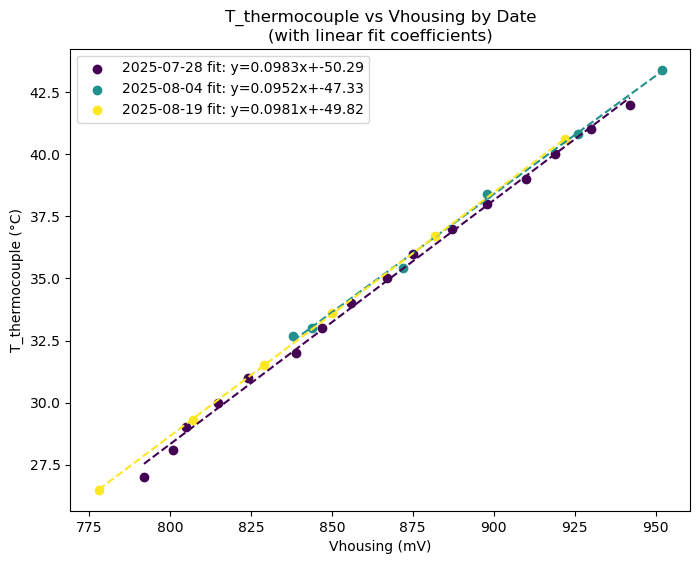

In [16]:
# Instead of conditions plot date, 

plt.figure(figsize=(8, 6))

unique_dates = dff['date'].unique()
colors = dict(zip(unique_dates, plt.cm.viridis(np.linspace(0, 1, len(unique_dates)))))

for i, date in enumerate(unique_dates):
    mask = dff['date'] == date
    x = dff.loc[mask, 'Vhousing']
    y = dff.loc[mask, 'T_thermocouple']
    
    # Linear regression for this condition
    if len(x) > 1:
        model = LinearRegression()
        model.fit(x.values.reshape(-1, 1), y.values)
        slope = model.coef_[0]
        intercept = model.intercept_
        plt.scatter(x, y, label=f"{date.strftime('%Y-%m-%d')} fit: y={slope:.3g}x+{intercept:.2f}", color=colors.get(date, None))
        plt.plot(x, model.predict(x.values.reshape(-1, 1)), color=colors.get(date, None), linestyle='--',
                 label=None)

plt.xlabel('Vhousing (mV)')
plt.ylabel('T_thermocouple (°C)')
plt.legend(loc='upper left')
plt.title('T_thermocouple vs Vhousing by Date\n(with linear fit coefficients)')
plt.show()

In [17]:
# I will use a mean for HousingSlope and HousingOffset
HousingSlope = 0.098
HousingOffset = -49.2

def derive_t_housing_from_v_housing(v_housing):
    """
    Derive T_housing from V_housing using the OPEN condition linear regression.
    """
    return HousingSlope * v_housing + HousingOffset

In [40]:
X_1 = pd.read_csv(Path("../calibration radiometer 6/data/all_X.csv"))
X_1 = X_1[X_1['condition'].str.contains("heating")]
X_1['condition'] = X_1['condition'].replace({ '25C-heating': '25C', '50C-heating': '50C'})
X_1["V_rad"] = X_1["V_rad_short"]
X_1["date"] = pd.to_datetime("28/07/25", format="%d/%m/%y")
X_1["V_rad_tot"] = X_1["V_rad_short"]

X_2 = pd.read_csv(Path("../calibration radiometer 6 v2/data/all_X.csv"))
X_2['condition'] = X_2['condition'].replace({'25C': 'V2 25C', '50C': 'V2 50C'})
X_2["V_rad"] = X_2["V_rad_tot"]
X_2["date"] = pd.to_datetime("04/08/25", format="%d/%m/%y")

X_3 = pd.read_csv(Path("../calibration radiometer 6 v3/data/all_X.csv"))
X_3 = X_3[X_3['condition'].isin(["25C", "50C"])]
X_3['condition'] = X_3['condition'].replace({'25C': 'V3 25C', '50C': 'V3 50C'})
X_3["V_rad"] = X_3["V_rad_tot"]
X_3["date"] = pd.to_datetime("19/08/25", format="%d/%m/%y")

X_4 = pd.read_csv(Path("../calibration radiometer 6 v4/data/all_X.csv"))
X_4 = X_4[X_4['condition'].isin(["25C", "50C"])]
X_4['condition'] = X_4['condition'].replace({'25C': 'V4 25C', '50C': 'V4 50C'})
X_4["V_rad"] = X_4["V_rad_tot"]
X_4["date"] = pd.to_datetime("20/08/25", format="%d/%m/%y")


all_X = pd.concat([X_1, X_2, X_3, X_4], ignore_index=True)
all_X.condition.unique()


array(['25C', '50C', 'V2 25C', 'V2 50C', 'V3 50C', 'V3 25C', 'V4 25C',
       'V4 50C'], dtype=object)

In [41]:
# Add temperature column: 25 if '25C' in condition, 50 if '50C' in condition
all_X['temperature'] = np.where(all_X['condition'].str.contains('25C'), 25, 50)

# Add run feature: 1 for X_1, 2 for X_2, 3 for X_3, 4 for X_4
run_map = dict(zip(
    pd.concat([X_1, X_2, X_3, X_4], ignore_index=True)['date'].unique(),
    [1, 2, 3, 4]
))
all_X['run'] = all_X['date'].map(run_map)

# Add setup feature: 'load' for run 1, 2, 4; 'long load' for run 3
all_X['setup'] = np.where(all_X['run'] == 3, 'long load', 'load')


In [42]:
all_X.columns

Index(['V_rad_short', 'V_rad_tot', 'V_housing', 'V_diode', 'V_spike',
       'time_index', 'condition', 'V_rad', 'date', 'temperature', 'run',
       'setup'],
      dtype='object')

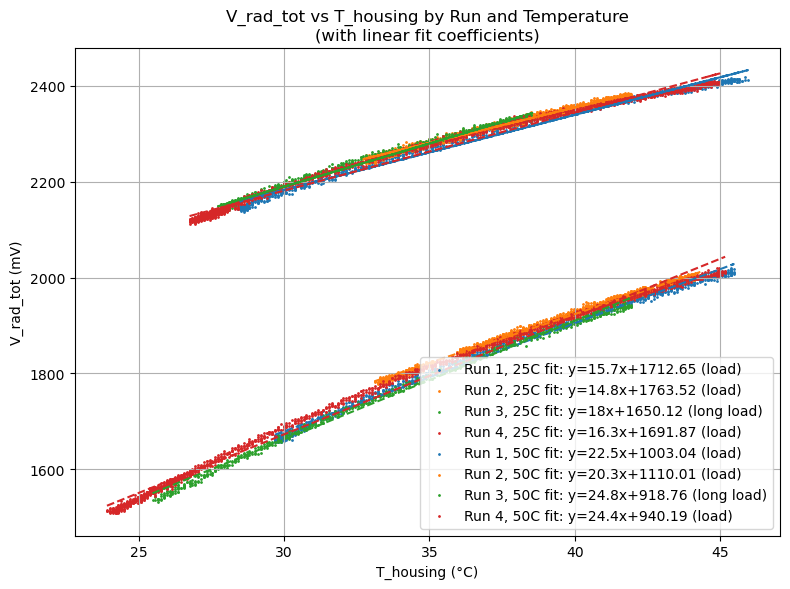

In [43]:
unique_runs = all_X['run'].unique()
# Use a discrete colormap with more than 4 nice colors

# Example: tab10 has 10 distinct colors
cmap = plt.get_cmap('tab10')
colors = dict(zip(unique_runs, [cmap(i % 10) for i in range(len(unique_runs))]))

plt.figure(figsize=(8, 6))
for temp in [25, 50]:
    for run in unique_runs:
    
        subset = all_X[(all_X['run'] == run) & (all_X['temperature'] == temp)]
        if subset.empty:
            continue
        T_housing = derive_t_housing_from_v_housing(subset['V_housing'])
        setup = subset['setup'].iloc[0]
        
        
        x_curve = T_housing.values.reshape(-1, 1)
        y_curve = subset['V_rad_tot'].values
        if len(x_curve) > 1:
            model_curve = LinearRegression()
            model_curve.fit(x_curve, y_curve)
            slope_curve = model_curve.coef_[0]
            intercept_curve = model_curve.intercept_
            plt.plot(T_housing, model_curve.predict(x_curve), color=colors[run], linestyle='--')
        label = f"Run {run}, {temp}C fit: y={slope_curve:.3g}x+{intercept_curve:.2f} ({setup})"
        plt.scatter(T_housing, subset['V_rad_tot'], label=label, color=colors[run], s=1)
plt.xlabel('T_housing (°C)')
plt.ylabel('V_rad_tot (mV)')
plt.title('V_rad_tot vs T_housing by Run and Temperature\n(with linear fit coefficients)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

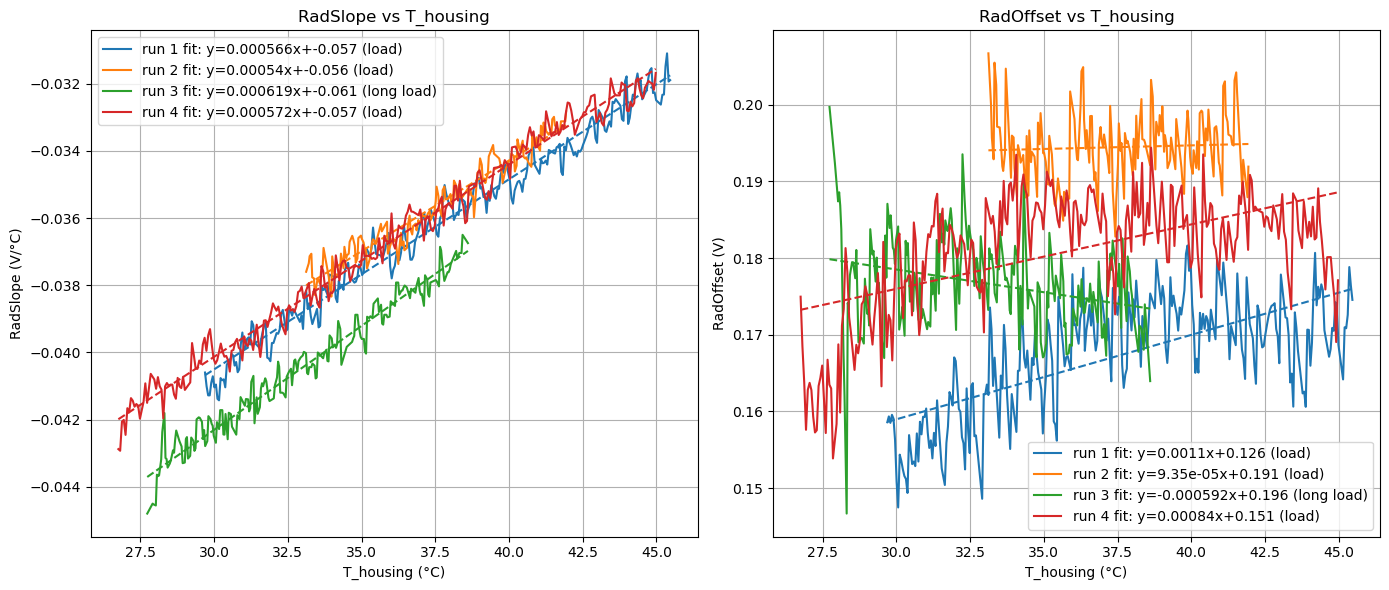

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cmap = plt.get_cmap('tab10')
colors = dict(zip(unique_runs, [cmap(i % 10) for i in range(len(unique_runs))]))

for run in [1, 2, 3, 4]:
    # Select conditions for v1 and v2
    cond_25 = all_X[(all_X['run'] == run) & (all_X['temperature'] == 25)]
    cond_50 = all_X[(all_X['run'] == run) & (all_X['temperature'] == 50)]
    setup = cond_25['setup'].iloc[0] if not cond_25.empty else cond_50['setup'].iloc[0]


    # Calculate T_housing for both conditions
    T_25 = derive_t_housing_from_v_housing(cond_25['V_housing'])
    T_50 = derive_t_housing_from_v_housing(cond_50['V_housing'])

    # Shared T_housing range
    T_min = max(T_25.min(), T_50.min())
    T_max = min(T_25.max(), T_50.max())
    T_shared = np.linspace(T_min, T_max, 300)

    # Interpolate V_rad_short
    V_25_interp = np.interp(T_shared, T_25, cond_25['V_rad_short'].values)
    V_50_interp = np.interp(T_shared, T_50, cond_50['V_rad_short'].values)

    # Calculate RadSlope and RadOffset
    RadSlope = (2 * (V_50_interp - V_25_interp) / (50 - 25)) * 1e-3
    RadOffset = (T_shared - 25) * RadSlope + 2 * V_25_interp / 1000 - 4

    # Linear regression
    model_rs = LinearRegression().fit(T_shared.reshape(-1, 1), RadSlope)
    model_ro = LinearRegression().fit(T_shared.reshape(-1, 1), RadOffset)

    # Plot
    label_rs = f'run {run} fit: y={model_rs.coef_[0]:.3g}x+{model_rs.intercept_:.3f} ({setup})'
    label_rs_fit = f''
    axes[0].plot(T_shared, RadSlope, color=colors[run], label=label_rs)
    axes[0].plot(T_shared, model_rs.predict(T_shared.reshape(-1, 1)), color=colors[run], linestyle='--', label=label_rs_fit)

    label_ro = f'run {run} fit: y={model_ro.coef_[0]:.3g}x+{model_ro.intercept_:.3f} ({setup})'
    label_ro_fit = f''
    axes[1].plot(T_shared, RadOffset, color=colors[run], label=label_ro)
    axes[1].plot(T_shared, model_ro.predict(T_shared.reshape(-1, 1)), color=colors[run], linestyle='--', label=label_ro_fit)

axes[0].set_xlabel('T_housing (°C)')
axes[0].set_ylabel('RadSlope (V/°C)')
axes[0].set_title('RadSlope vs T_housing')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel('T_housing (°C)')
axes[1].set_ylabel('RadOffset (V)')
axes[1].set_title('RadOffset vs T_housing')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [48]:
rad_slope_params = {}
rad_offset_params = {}

for run in [1, 2, 3, 4]:
    cond_25 = all_X[(all_X['run'] == run) & (all_X['temperature'] == 25)]
    cond_50 = all_X[(all_X['run'] == run) & (all_X['temperature'] == 50)]
    setup = cond_25['setup'].iloc[0] if not cond_25.empty else cond_50['setup'].iloc[0]

    T_25 = derive_t_housing_from_v_housing(cond_25['V_housing'])
    T_50 = derive_t_housing_from_v_housing(cond_50['V_housing'])
    T_min = max(T_25.min(), T_50.min())
    T_max = min(T_25.max(), T_50.max())
    T_shared = np.linspace(T_min, T_max, 300)

    V_25_interp = np.interp(T_shared, T_25, cond_25['V_rad_short'].values)
    V_50_interp = np.interp(T_shared, T_50, cond_50['V_rad_short'].values)

    RadSlope = (2 * (V_50_interp - V_25_interp) / (50 - 25)) * 1e-3
    RadOffset = (T_shared - 25) * RadSlope + 2 * V_25_interp / 1000 - 4

    model_rs = LinearRegression().fit(T_shared.reshape(-1, 1), RadSlope)
    model_ro = LinearRegression().fit(T_shared.reshape(-1, 1), RadOffset)

    rad_slope_params[run] = (model_rs.coef_[0], model_rs.intercept_)
    rad_offset_params[run] = (model_ro.coef_[0], model_ro.intercept_)


In [50]:
print(rad_slope_params)
print(rad_offset_params)

{1: (np.float64(0.0005659322507751434), np.float64(-0.05748323471854578)), 2: (np.float64(0.0005401346491823383), np.float64(-0.05589165650532932)), 3: (np.float64(0.000618790867881889), np.float64(-0.06086926396604231)), 4: (np.float64(0.0005723346566430906), np.float64(-0.057300633760184475))}
{1: (np.float64(0.0011000315190813552), np.float64(0.12597363119966848)), 2: (np.float64(9.345069824347584e-05), np.float64(0.1909492769142828)), 3: (np.float64(-0.000592006367510607), np.float64(0.19625924093911845)), 4: (np.float64(0.0008403065523668446), np.float64(0.15077077786096638))}


In [55]:
import os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from calibration_funcs import T_rad_func, T_housing_func

1.624308829813323
1.1883864572579128
2.3274383309676665
1.6485740252212935


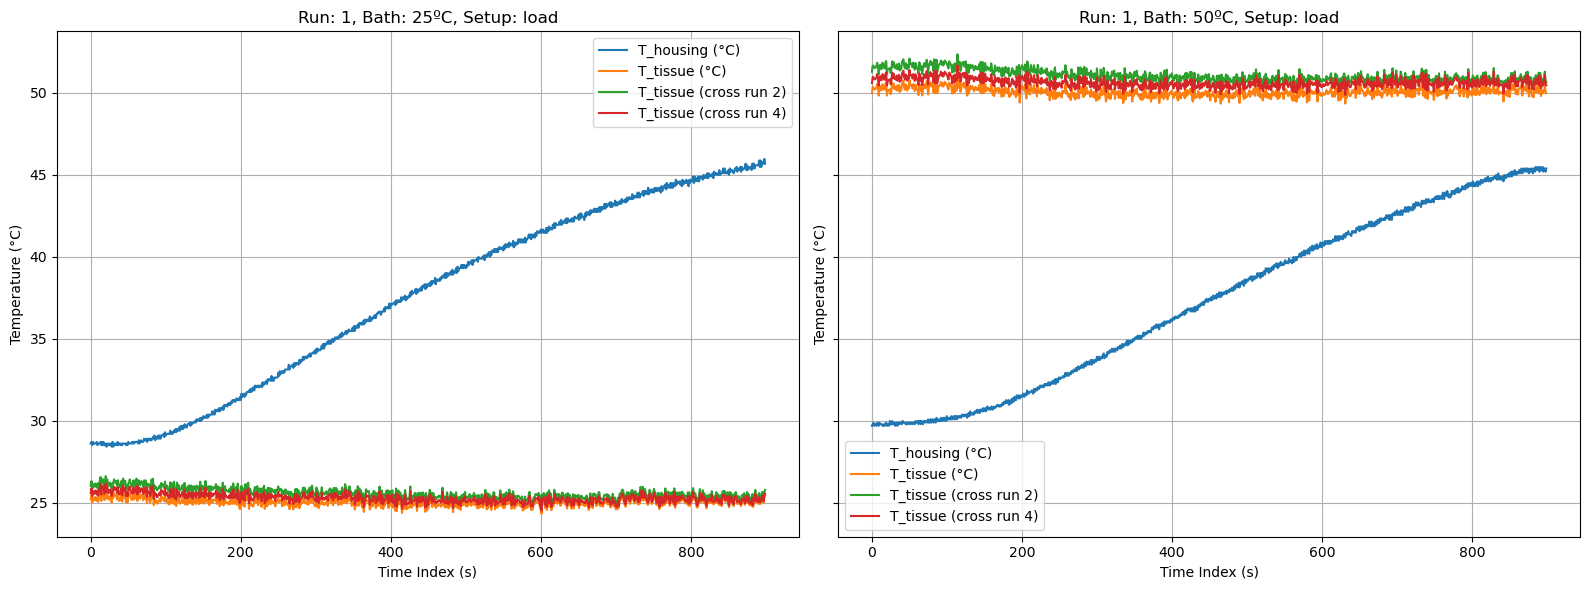

0.15768459447911098
0.3837938403484884
-0.08747829104922289
0.43164952068286055


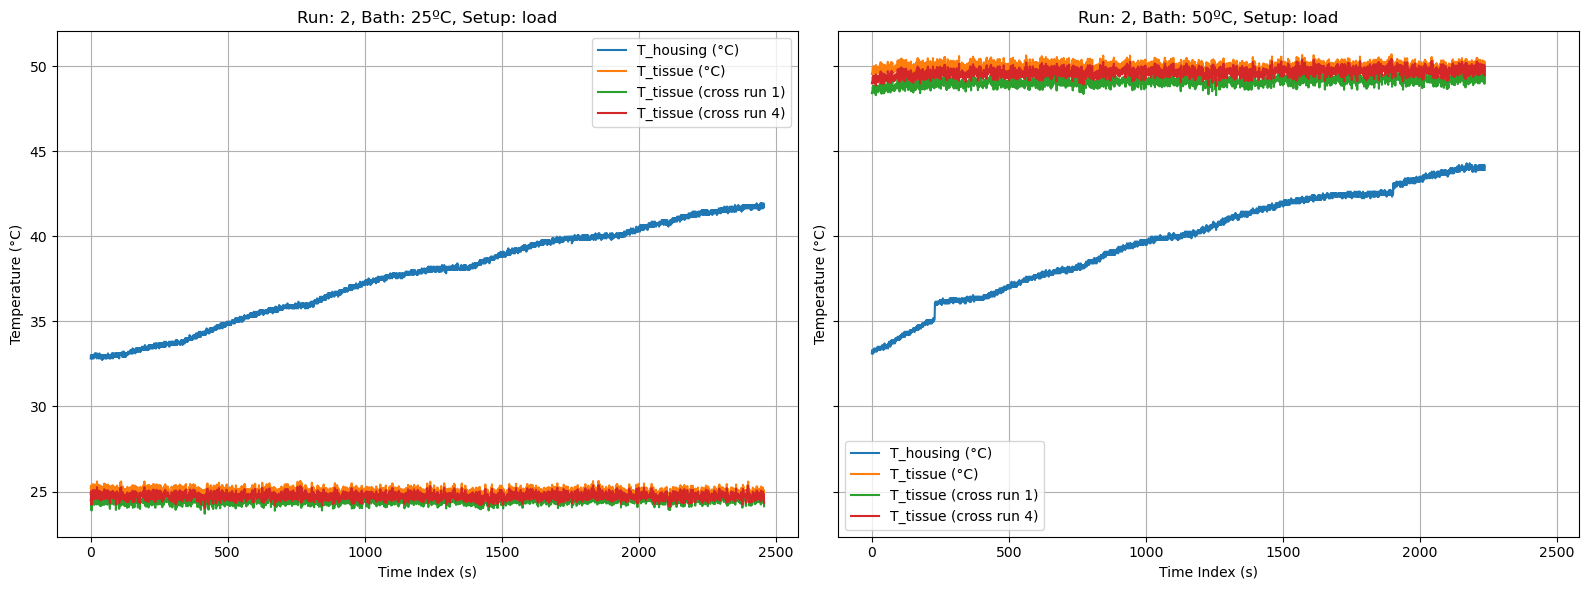

0.550132809399738
1.3041773809091524
0.4548275028688238
1.9133720663089946


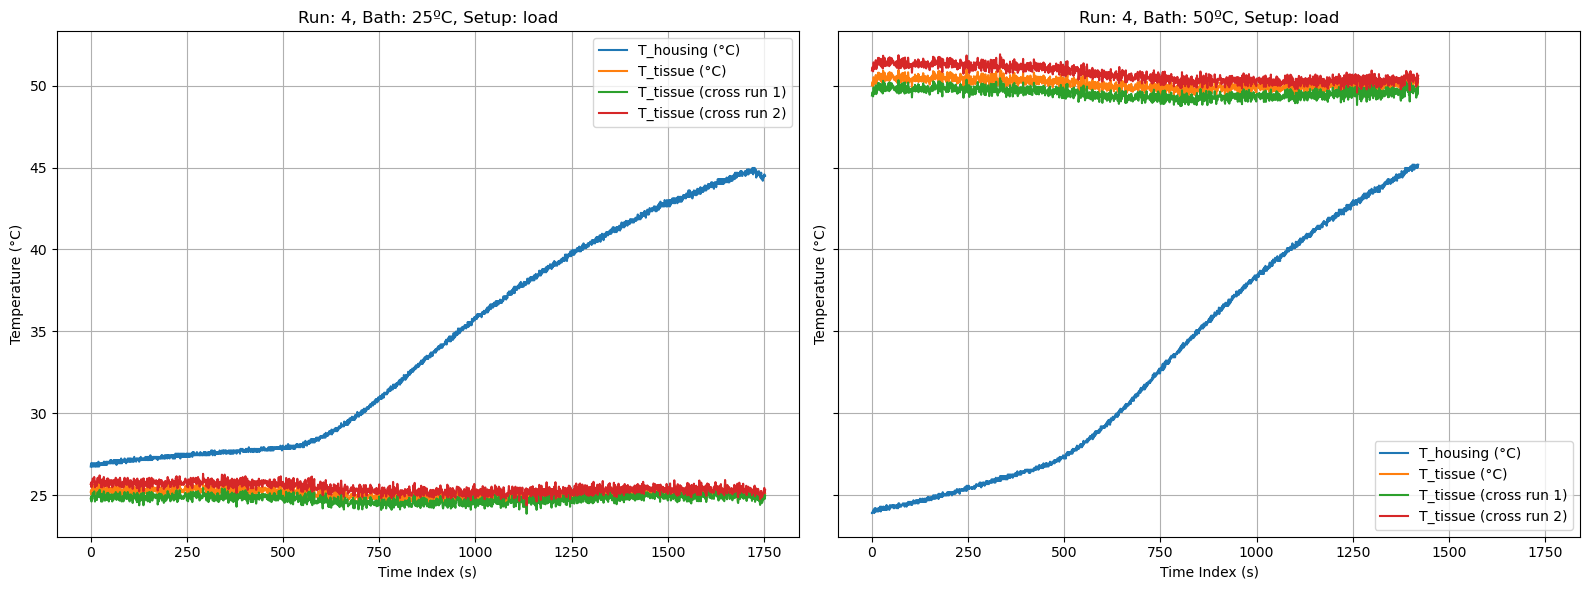

In [69]:
temp_vars = ['T_tissue', 'T_housing']
temp_labels = {
    # 'T_rad-tot': 'T_rad-tot (°C)',
    'T_tissue': 'T_tissue (°C)',
    'T_housing': 'T_housing (°C)'
}
for run in [1, 2, 4]:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
    for idx, temp in enumerate([25, 50]):
        subset = all_X[(all_X['run'] == run) & (all_X['temperature'] == temp)]
        V_housing_V = subset['V_housing']
        T_housing = T_housing_func(V_housing_V, HousingSlope, HousingOffset)
        axes[idx].plot(subset['time_index'], T_housing, label=temp_labels["T_housing"])
        V_rad_tot_V = subset['V_rad_tot'] / 1000
        T_tissue = T_rad_func(
            V_rad_tot_V, T_housing,
            rad_offset_params[run][0], rad_offset_params[run][1],
            rad_slope_params[run][0], rad_slope_params[run][1]
        )
        axes[idx].plot(subset['time_index'], T_tissue, label=temp_labels["T_tissue"])
        for other_run in [r for r in [1, 2, 4] if r != run]:
            T_tissue_cross = T_rad_func(
                V_rad_tot_V, T_housing,
                rad_offset_params[other_run][0], rad_offset_params[other_run][1],
                rad_slope_params[other_run][0], rad_slope_params[other_run][1]
            )
            print(max(T_tissue_cross - temp))
            axes[idx].plot(
                subset['time_index'],
                T_tissue_cross,
                label=f"T_tissue (cross run {other_run})"
            )
        setup = subset['setup'].iloc[0]
        handles, plot_labels = axes[idx].get_legend_handles_labels()
        by_label = dict(zip(plot_labels, handles))
        axes[idx].set_title(f"Run: {run}, Bath: {temp}ºC, Setup: {setup}")
        axes[idx].set_xlabel("Time Index (s)")
        axes[idx].set_ylabel("Temperature (°C)")
        axes[idx].legend(by_label.values(), by_label.keys())
        axes[idx].grid(True)
    plt.tight_layout()
    plt.show()
